# Rivercats - All products
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* Jan 24, 2022

## Hypothesis
The goal of this notebook is to compare the results of the model with the model using standard StellarAlgo features with the engineered retention model features.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from pycaret.classification import *

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
# connect to SQL Server.
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'nrad' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

In [3]:
lkupclientid = 12 # Rivercats
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrMILB].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.shape

(6435, 54)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 54 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   lkupClientId            6435 non-null   int64  
 1   dimCustomerMasterId     6435 non-null   int64  
 2   customerNumber          6435 non-null   object 
 3   year                    6435 non-null   int64  
 4   productGrouping         6435 non-null   object 
 5   totalSpent              6435 non-null   float64
 6   recentDate              6435 non-null   object 
 7   attendancePercent       6435 non-null   float64
 8   renewedBeforeDays       6435 non-null   int64  
 9   isBuyer                 6435 non-null   object 
 10  source_tenure           6435 non-null   int64  
 11  tenure                  6435 non-null   int64  
 12  distToVenue             6435 non-null   float64
 13  totalGames              6435 non-null   int64  
 14  recency                 6435 non-null   

### We should specify the features used in our model:

In [5]:
# choose the features for the stellar base retention model
features = ["year",
            "isNextYear_Buyer",
            "productGrouping",
            "dimCustomerMasterId",
         "totalSpent",
        "attendancePercent",
        "renewedBeforeDays",
        "source_tenure",
        "totalGames",
        "recency",
        "missed_games_1",
        "missed_games_2",
        "missed_games_over_2",
        "NumberofGamesPerSeason"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2019]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (4562, 14)
Unseen Data For Predictions: (805, 14)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [6]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","productGrouping","year"],
    silent=True,
    verbose=False,
    numeric_features=[
     "totalSpent",
        "attendancePercent",
        "renewedBeforeDays",
        "source_tenure",
        "totalGames",
        "recency",
        "missed_games_1",
        "missed_games_2",
        "missed_games_over_2",
        "NumberofGamesPerSeason"
    ]
);

In [7]:
model_matrix = compare_models(
    fold=10,
    include=["lr", "xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7491,0.8421,0.7686,0.7073,0.7363,0.4978,0.4998,0.4560
xgboost,Extreme Gradient Boosting,0.7410,0.8256,0.7584,0.6996,0.7276,0.4816,0.4834,0.3920


In [8]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7577,0.8591,0.7684,0.7196,0.7432,0.5144,0.5154
1,0.7371,0.8299,0.7514,0.6963,0.7228,0.4735,0.4748
2,0.7423,0.8448,0.7571,0.7016,0.7283,0.4838,0.4851
3,0.7242,0.8335,0.7288,0.6862,0.7068,0.4470,0.4477
4,0.7655,0.8647,0.8079,0.7150,0.7586,0.5322,0.5360
5,0.7139,0.8046,0.7062,0.6793,0.6925,0.4252,0.4255
6,0.7345,0.8349,0.7966,0.6779,0.7325,0.4724,0.4785
7,0.7494,0.8343,0.7955,0.6965,0.7427,0.5005,0.5047
8,0.7597,0.8330,0.7841,0.7150,0.7480,0.5193,0.5213
9,0.8062,0.8823,0.7898,0.7853,0.7875,0.6094,0.6094


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Let's load in our 2021 season data and get retention scores using the model:

In [9]:
df_inference = df.loc[df["year"] >= 2021]
df_inference = df_inference.fillna(0)
df_inference.shape

(1068, 54)

In [10]:
new_predictions = predict_model(final_model, data=df_inference, raw_score=True)
new_predictions.head()

,lkupClientId,dimCustomerMasterId,customerNumber,year,productGrouping,totalSpent,recentDate,attendancePercent,renewedBeforeDays,isBuyer,...,education,urbanicity,credits_after_refund,is_Lockdown,NumberofGamesPerSeason,CNTPostponedGames,isNextYear_Buyer,Label,Score_0,Score_1
5367,12,322134435,4257653,2021,Quarter Season,816.0,2021-10-03,1.062500,19,TRUE,...,College Certificate/Diploma,0,0.0,1,132,0,1,0,0.9878,0.0122
5368,12,322135757,3767192,2021,Quarter Season,578.0,2021-10-03,0.656250,21,TRUE,...,College Certificate/Diploma,0,0.0,1,132,0,1,0,0.9927,0.0073
5369,12,322139999,3861815,2021,Quarter Season,306.0,2021-10-03,1.125000,10,TRUE,...,College Certificate/Diploma,0,0.0,1,132,0,1,0,0.9868,0.0132
5370,12,322176057,3647589,2021,Half Season,2244.0,2021-10-03,0.203125,20,TRUE,...,College Certificate/Diploma,0,0.0,1,132,0,0,0,0.9948,0.0052
5371,12,322620777,3758896,2021,Quarter Season,528.0,2021-09-21,0.909091,5,TRUE,...,College Certificate/Diploma,0,0.0,1,132,0,1,0,0.9903,0.0097


In [11]:
new_predictions["Label"].value_counts()

0    1068
Name: Label, dtype: int64

In [12]:
new_predictions["Score_1"].value_counts(bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

(-0.001, 0.2]    1068
(0.2, 0.4]          0
(0.4, 0.6]          0
(0.6, 0.8]          0
(0.8, 1.0]          0
Name: Score_1, dtype: int64

array([[<AxesSubplot:title={'center':'Score_1'}>]], dtype=object)

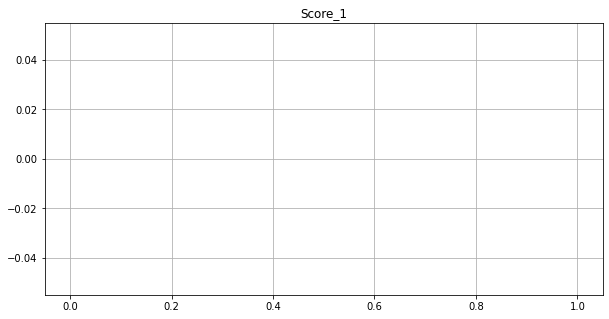

In [13]:
new_predictions[new_predictions["Label"]==1][["Score_1"]].hist(bins=30, figsize=(10,5), range=[0,1])

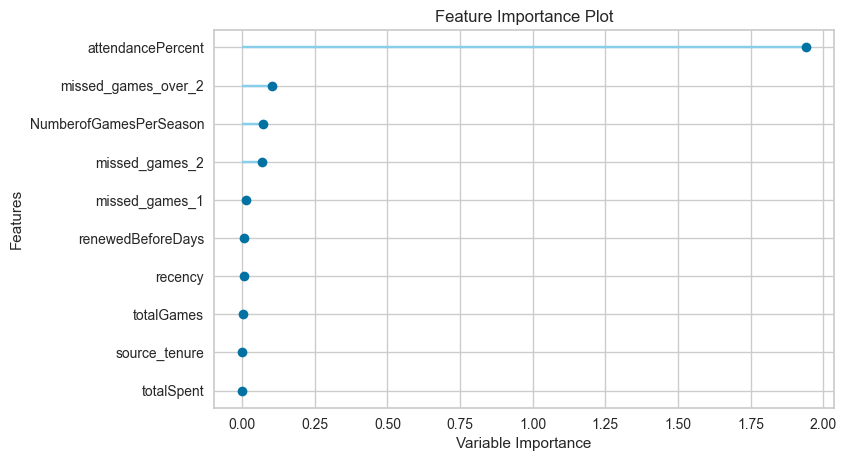

In [14]:
plot_model(best_model, plot='feature')

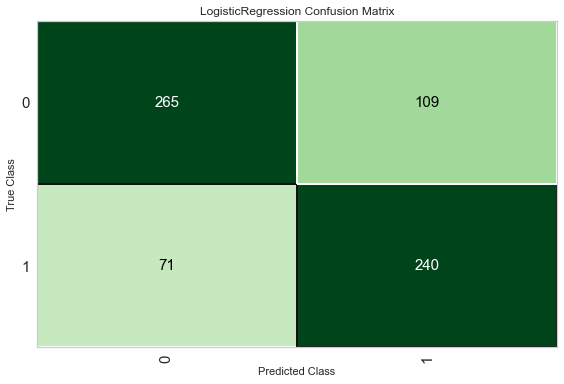

In [15]:
plot_model(best_model, plot='confusion_matrix')

## Observations
Here you can document some ideas on the results from above

* the distribution doesn't look normal
* The ticketing data are in the top 3 feature importance
* The model makes more predictions of customers who won't buy
* The accuracy and the AUC decreased compared to using Full Season product

## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?